In [ ]:
import torch
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm

from bliss.datasets.lsst import convert_flux_to_mag
from bliss.datasets.io import load_dataset_npz

from bliss.encoders.detection import DetectionEncoder

In [ ]:
detection = DetectionEncoder().eval()
detection.load_state_dict(torch.load("../../models/detection_23_23.pt"))
detection = detection.eval().requires_grad_(False)

In [ ]:
true_ds = load_dataset_npz("../../data/datasets/test_ds_251.npz")
images = true_ds['images']
tplocs = true_ds['plocs']


In [ ]:
ds = torch.load("../../data/cache/score_test2.pt")

In [ ]:
ds.keys()

dict_keys(['map', 'samples', 'truth'])

In [ ]:
n_true = ds['truth']['n_sources']
n_misses = ds['map']['n_misses']
n_true.shape, n_misses.shape

(torch.Size([1500]), torch.Size([1500]))

(array([1200.,  264.,   33.,    3.,    0.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

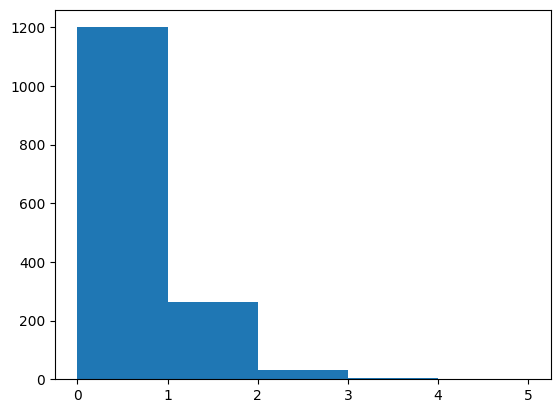

In [ ]:
plt.hist(n_misses, range=(0, 5), bins=5)

In [ ]:
n_misses

tensor([0, 0, 0,  ..., 0, 0, 1])

In [ ]:
grades = ds['map']['grades']
grades.shape

torch.Size([1500, 7])

In [ ]:
mask = grades.ravel() > 0
_grades = grades.ravel()[mask]
_grades.shape

torch.Size([3455])

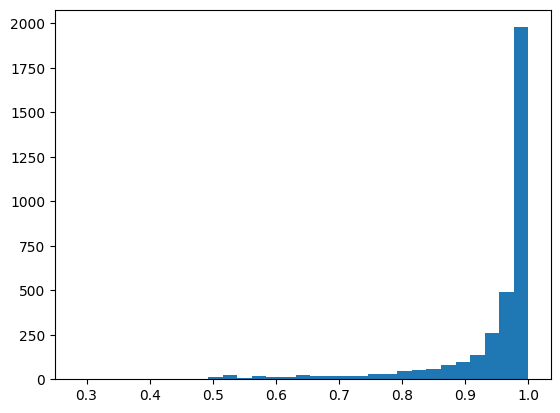

In [ ]:
plt.hist(_grades, bins=31);

In [ ]:
grades[101]

tensor([0.8957, 0.8797, 0.9958, 0.0000, 0.0000, 0.0000, 0.0000])

In [ ]:
n_true.shape

torch.Size([1500])

In [ ]:
scores = [] 
for ii in range(len(grades)):
    _gg = grades[ii]
    _nt = n_true[ii]
    _nmiss = n_misses[ii]

    if _nt == 0:
        score = torch.nan
    else: 
        score = _gg.sum() / (_nt + _nmiss)
    
    scores.append(score)
scores = torch.tensor(scores)


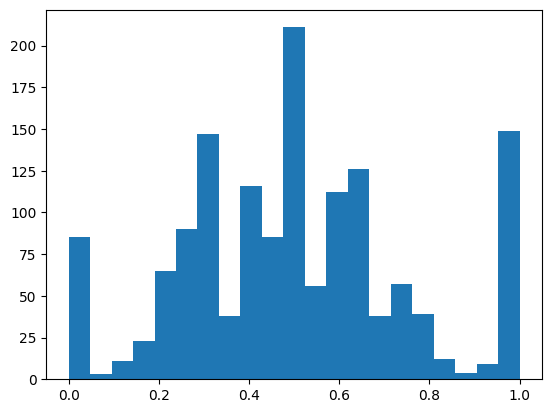

In [ ]:
plt.hist(scores, bins=21);
plt.axvline(torch.median(scores).item(), color='red', linestyle='--', label='Median Score')

In [ ]:
# bin score by blendedness
bld = ds['truth']['bld'].ravel()
bld_mask = (bld > 1e-4) * (bld <= 1)
_bld = bld[bld_mask]
qs = torch.linspace(0, 1, 12)
_bld_bins = torch.quantile(_bld, qs)
bld_bins = torch.column_stack((_bld_bins[:-1], _bld_bins[1:]))

In [ ]:
bld_bins

tensor([[1.0252e-04, 4.1010e-03],
        [4.1010e-03, 9.5468e-03],
        [9.5468e-03, 1.8028e-02],
        [1.8028e-02, 3.0100e-02],
        [3.0100e-02, 5.0317e-02],
        [5.0317e-02, 8.1126e-02],
        [8.1126e-02, 1.3654e-01],
        [1.3654e-01, 2.2267e-01],
        [2.2267e-01, 3.7762e-01],
        [3.7762e-01, 6.3739e-01],
        [6.3739e-01, 9.9765e-01]])

In [ ]:
grades.shape

torch.Size([1500, 7])

In [ ]:
ds['truth']['bld'].shape

torch.Size([1500, 10, 1])

In [ ]:
sum(ds['truth']['n_sources'] == 0) 

tensor(24)

In [ ]:
grades.shape

torch.Size([1500, 7])

In [ ]:
binned_scores = []
for bb in tqdm(bld_bins):
    scores = [] 
    for ii in range(len(grades)):
        bld_ii = ds['map']['blds'][ii]
        snr_ii = ds['map']['snrs'][ii]
        assert bld_ii.shape[0] == grades[ii].shape[0]
        mask = (bld_ii > bb[0]) & (bld_ii <= bb[1]) & (snr_ii > 10)
        _gg = grades[ii][mask].sum()

        _blds = ds['truth']['bld'][ii]
        _snrs = ds['truth']['snr'][ii]
        _nt = torch.sum( (_blds > bb[0]) & (_blds <= bb[1]) & (_snrs > 10)).item()
        _nmiss = n_misses[ii].item()

        score = _gg / (_nt + _nmiss) if _nt > 0 else torch.nan
        scores.append(score)
    
    binned_scores.append(torch.tensor(scores))

binned_scores = torch.stack(binned_scores)

100%|██████████| 11/11 [00:01<00:00,  7.40it/s]


In [ ]:
bld_ii, grades[ii-1]

(tensor([0.1074, 0.0013, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]),
 tensor([0.9959, 0.7850, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]))

(array([47.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]),
 array([0.        , 0.0498485 , 0.099697  , 0.14954551, 0.199394  ,
        0.2492425 , 0.29909101, 0.34893951, 0.39878801, 0.4486365 ,
        0.498485  ]),
 <BarContainer object of 10 artists>)

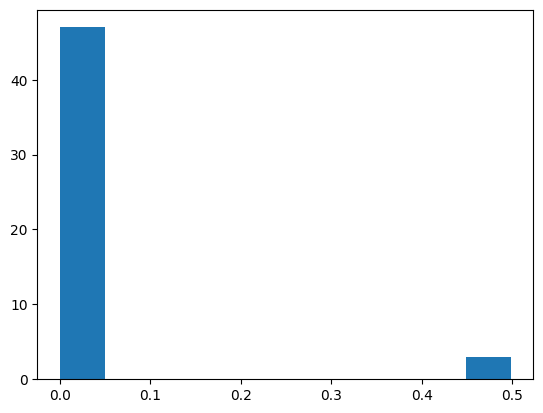

In [ ]:
plt.hist(binned_scores[-1])

In [ ]:
torch.where(binned_scores[0] == 0)[0]

tensor([   3,  167,  180,  194,  380,  426,  432,  460,  465,  531,  545,  628,
         644,  667,  681,  717,  738,  771,  805,  846,  881,  882,  891,  935,
         967,  987, 1024, 1045, 1158, 1199, 1307, 1312, 1333, 1497])

In [ ]:
binned_scores.shape

torch.Size([11, 1500])

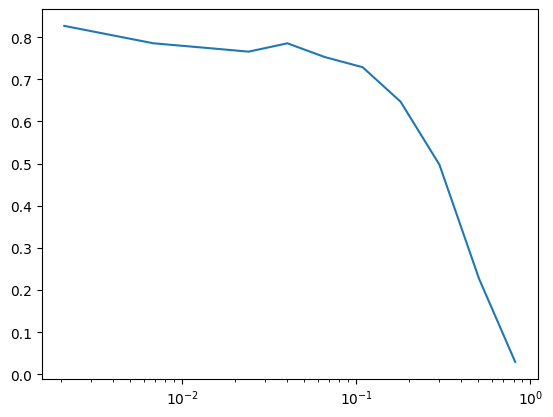

In [ ]:
x = bld_bins.mean(dim=1)
y = torch.nanmean(binned_scores, dim=1)
plt.plot(x, y)
plt.xscale('log')

# Sample grades

In [ ]:
grades = ds['samples']['grades']
grades.shape

torch.Size([100, 1500, 10])

tensor(319207)

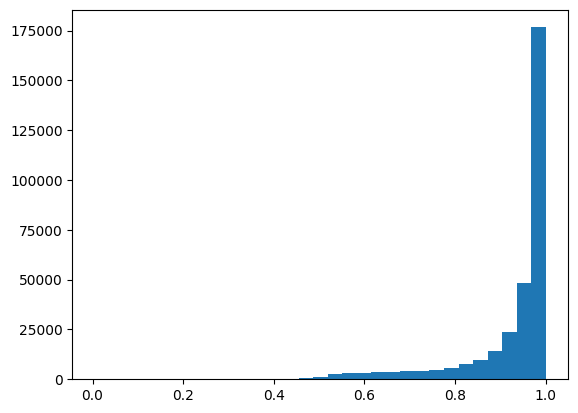

In [ ]:
mask = grades.ravel() > 0
plt.hist(grades.ravel()[mask], bins=31)
sum(mask)

In [ ]:
n_misses = ds['samples']['n_misses']
n_misses.shape

torch.Size([100, 1500])

(array([3.0991e+04, 4.8798e+04, 3.8712e+04, 2.0188e+04, 8.0150e+03,
        2.5100e+03, 6.3400e+02, 1.2800e+02, 1.8000e+01, 5.0000e+00,
        1.0000e+00]),
 array([ 0.        ,  0.90909091,  1.81818182,  2.72727273,  3.63636364,
         4.54545455,  5.45454545,  6.36363636,  7.27272727,  8.18181818,
         9.09090909, 10.        ]),
 <BarContainer object of 11 artists>)

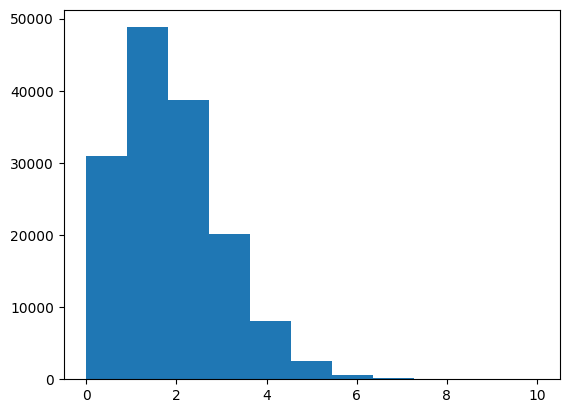

In [ ]:
plt.hist(n_misses.ravel(), bins=11)

In [ ]:
n_true = ds['truth']['n_sources']
n_true.shape

torch.Size([1500])

In [ ]:
# raw scores 
# average over samples 
scores = [] 
for ii in range(grades.shape[1]):
    _per_image_scores = [] 
    for jj in range(grades.shape[0]):
        _gg = grades[jj, ii]
        _nt = n_true[jj]
        _nmiss = n_misses[jj, ii]

        if _nt == 0:
            score = torch.nan
        else: 
            score = _gg.sum() / (_nt + _nmiss)
        
        _per_image_scores.append(score)
    scores.append(torch.tensor(_per_image_scores).nanmean())
scores = torch.tensor(scores)


In [ ]:
torch.sum(torch.isnan(scores)) 

tensor(0)

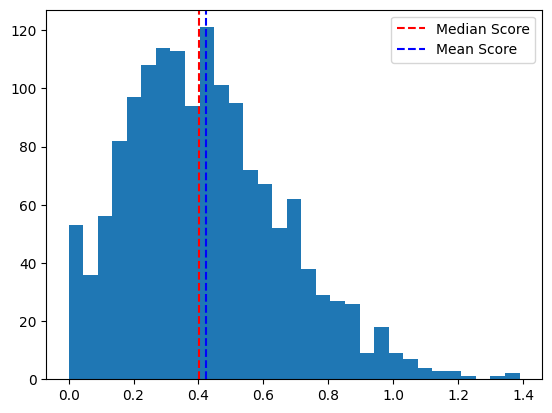

In [ ]:
plt.hist(scores, bins=31);
plt.axvline(torch.median(scores).item(), color='red', linestyle='--', label='Median Score') 
plt.axvline(torch.mean(scores).item(), color='blue', linestyle='--', label='Mean Score')
plt.legend()

In [ ]:
# bin score by blendedness
bld = ds['truth']['bld'].ravel()
bld_mask = (bld > 1e-4) * (bld <= 1)
_bld = bld[bld_mask]
qs = torch.linspace(0, 1, 12)
_bld_bins = torch.quantile(_bld, qs)
bld_bins = torch.column_stack((_bld_bins[:-1], _bld_bins[1:]))
bld_bins

tensor([[1.0252e-04, 4.1010e-03],
        [4.1010e-03, 9.5468e-03],
        [9.5468e-03, 1.8028e-02],
        [1.8028e-02, 3.0100e-02],
        [3.0100e-02, 5.0317e-02],
        [5.0317e-02, 8.1126e-02],
        [8.1126e-02, 1.3654e-01],
        [1.3654e-01, 2.2267e-01],
        [2.2267e-01, 3.7762e-01],
        [3.7762e-01, 6.3739e-01],
        [6.3739e-01, 9.9765e-01]])

In [ ]:
grades.shape

torch.Size([100, 1500, 10])

In [ ]:
ds['truth']['bld'].shape

torch.Size([1500, 10, 1])

In [ ]:
ds['samples']['blds'][jj, ii].shape

torch.Size([10])

In [ ]:
ds['truth']['bld'].shape

torch.Size([1500, 10, 1])

In [ ]:
# bin sampled score by blendedness
binned_scores = []
for bb in tqdm(bld_bins):
    scores = [] 
    for ii in range(grades.shape[1]): # image
        _per_image_scores = [] 
        for jj in range(grades.shape[0]): # sample 
            bld_ii = ds['samples']['blds'][jj, ii] # there are truth matched, convenience
            snr_ii = ds['samples']['snrs'][jj, ii]
            assert bld_ii.shape[0] == grades[jj, ii].shape[0]
            mask = (bld_ii > bb[0]) & (bld_ii <= bb[1]) & (snr_ii > 5)
            _gg = grades[jj, ii][mask].sum()

            _blds = ds['truth']['bld'][ii, :, 0]
            _snrs = ds['truth']['snr'][ii, :, 0]
            _nt = torch.sum( (_blds > bb[0]) & (_blds <= bb[1]) & (_snrs > 5)).item()
            _nmiss = n_misses[jj, ii].item()

            score = _gg / (_nt + _nmiss) if _nt > 0 else torch.nan
            _per_image_scores.append(score)
        
        scores.append(torch.tensor(_per_image_scores).nanmean())
    
    binned_scores.append(torch.tensor(scores))
binned_scores = torch.stack(binned_scores)
binned_scores.shape

100%|██████████| 11/11 [02:27<00:00, 13.38s/it]


torch.Size([11, 1500])

(array([ 1.,  2.,  5.,  4., 16., 16., 16., 20., 30., 44., 44., 40., 47.,
        46., 42., 25., 17., 16.,  4.,  3.,  3.]),
 array([0.0110474 , 0.04906919, 0.08709099, 0.12511279, 0.16313457,
        0.20115638, 0.23917817, 0.27719995, 0.31522176, 0.35324356,
        0.39126536, 0.42928714, 0.46730894, 0.50533074, 0.54335254,
        0.58137435, 0.61939615, 0.65741795, 0.69543976, 0.73346156,
        0.77148336, 0.80950511]),
 <BarContainer object of 21 artists>)

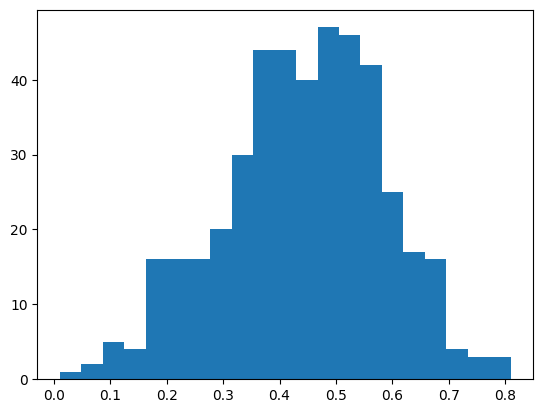

In [ ]:
plt.hist(binned_scores[0], bins=21)

In [ ]:
binned_scores.shape

torch.Size([11, 1500])

In [ ]:
binned_scores

tensor([[0.4065,    nan, 0.3273,  ..., 0.2178, 0.3599, 0.3260],
        [0.2132,    nan,    nan,  ...,    nan,    nan,    nan],
        [0.5086,    nan, 0.2493,  ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan, 0.3240,  ...,    nan,    nan,    nan],
        [   nan, 0.1488,    nan,  ...,    nan,    nan,    nan],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan]])

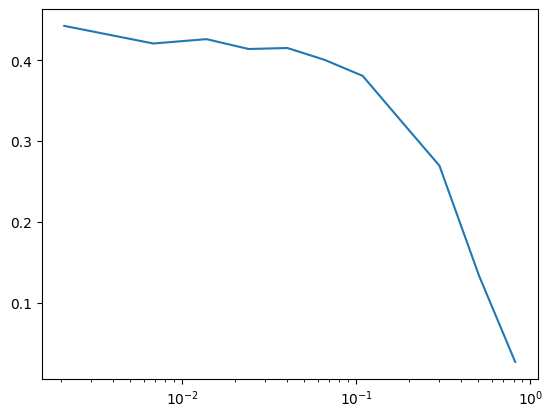

In [ ]:
x = bld_bins.mean(dim=1)
y = torch.nanmean(binned_scores, dim=1)
plt.plot(x, y)
plt.xscale('log')

# Example image (tile boundary problem)

In [ ]:
idx = 380
# idx = 3

In [ ]:
# probs, _, _ = detection.forward(images[79, None])
map_tile_cat = detection.variational_mode(images[idx, None])
# map_tile_cat[]
cat = map_tile_cat.to_full_params()
cat.batch_size

1

In [ ]:
probs, _, _ = detection.forward(images[idx, None])


In [ ]:
bld_bins

tensor([[1.0252e-04, 4.1010e-03],
        [4.1010e-03, 9.5468e-03],
        [9.5468e-03, 1.8028e-02],
        [1.8028e-02, 3.0100e-02],
        [3.0100e-02, 5.0317e-02],
        [5.0317e-02, 8.1126e-02],
        [8.1126e-02, 1.3654e-01],
        [1.3654e-01, 2.2267e-01],
        [2.2267e-01, 3.7762e-01],
        [3.7762e-01, 6.3739e-01],
        [6.3739e-01, 9.9765e-01]])

In [ ]:
ds['map']['blds'][idx]

tensor([0.0160, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [ ]:
grades[idx]

tensor([0.9946, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [ ]:
binned_scores[0][idx]

tensor(0.)

In [ ]:
ds['truth']['snr'][idx], ds['truth']['bld'][idx]

(tensor([[31.0490],
         [ 6.9343],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]]),
 tensor([[0.0013],
         [0.0160],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000]]))

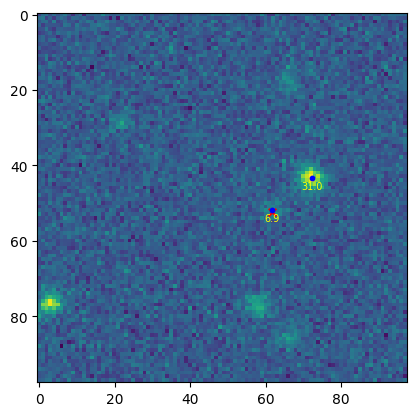

In [ ]:
plocs = cat.plocs[0]
bp = 24 
for y,x in plocs:
    _y = y - 0.5 + bp
    _x = x - 0.5 + bp
    plt.scatter(_x, _y, color='red', s=30, marker='x')

_tplocs = tplocs[idx]
for ii, (y, x) in enumerate(_tplocs):
    if y == 0 or x == 0:
        continue
    _snr = ds['truth']['snr'][idx][ii].item()
    _y = y - 0.5 + bp
    _x = x - 0.5 + bp
    plt.scatter(_x, _y, color='blue', s=10, marker='o')
    plt.text(_x, _y+2, f"{_snr:.1f}", fontsize=7, color='yellow', ha='center', va='center')

plt.imshow(images[idx, 0])

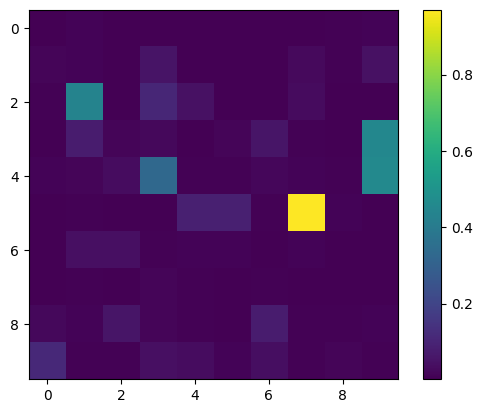

In [ ]:
plt.imshow(probs.reshape(10, 10))
plt.colorbar()

In [ ]:
probs.reshape(10, 10)[3, -1], probs.reshape(10, 10)[4, -1]

(tensor(0.4497), tensor(0.4585))

In [ ]:
ds['truth'].keys()

dict_keys(['snr', 'bld', 'n_sources'])